### train.csv : 학습 데이터
- id: 데이터 고유 id
- age: 나이
- sex: 성별 (여자 = 0, 남자 = 1)
- cp: 가슴 통증(chest pain) 종류 
    - 0 : asymptomatic 무증상
    - 1 : atypical angina 일반적이지 않은 협심증
    - 2 : non-anginal pain 협심증이 아닌 통증
    - 3 : typical angina 일반적인 협심증
- trestbps: (resting blood pressure) 휴식 중 혈압(mmHg)
- chol: (serum cholestoral) 혈중 콜레스테롤 (mg/dl)
- fbs: (fasting blood sugar) 공복 중 혈당 (120 mg/dl 이하일 시 = 0, 초과일 시 = 1)
- restecg: (resting electrocardiographic) 휴식 중 심전도 결과 
    - 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    - 1: 정상
    - 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- thalach: (maximum heart rate achieved) 최대 심박수
- exang: (exercise induced angina) 활동으로 인한  협심증 여부 (없음 = 0, 있음 = 1)
- oldpeak: (ST depression induced by exercise relative to rest) 휴식 대비 운동으로 인한 ST 하강
- slope: (the slope of the peak exercise ST segment) 활동 ST 분절 피크의 기울기
    - 0: downsloping 하강
    - 1: flat 평탄
    - 2: upsloping 상승
- ca: number of major vessels colored by flouroscopy 형광 투시로 확인된 주요 혈관 수 (0~3 개) / Null 값은 숫자 4로 인코딩됨 
- thal: thalassemia 지중해빈혈 여부
    - 0 = Null 
    - 1 = normal 정상
    - 2 = fixed defect 고정 결함
    - 3 = reversable defect 가역 결함
- target: 심장 질환 진단 여부
    - 0: < 50% diameter narrowing
    - 1: > 50% diameter narrowing


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 애초에 데이터가 너무 적어서 쉬운 문제이기는하다.
train = pd.read_csv("./dataset/train.csv")
train

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
1,2,52,1,3,152,298,1,1,178,0,1.2,1,0,3,1
2,3,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
3,4,45,0,0,138,236,0,0,152,1,0.2,1,0,2,1
4,5,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0
147,148,51,1,2,94,227,0,1,154,1,0.0,2,1,3,1
148,149,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1
149,150,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


In [3]:
# 결측 값 확인하기 -> 가장 일반적인 방법
train.isnull().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
# 결측값 조금 더 Fancy하게 가져오기

def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(dataframe.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')

check_missing_col(train)

결측치가 존재하지 않습니다


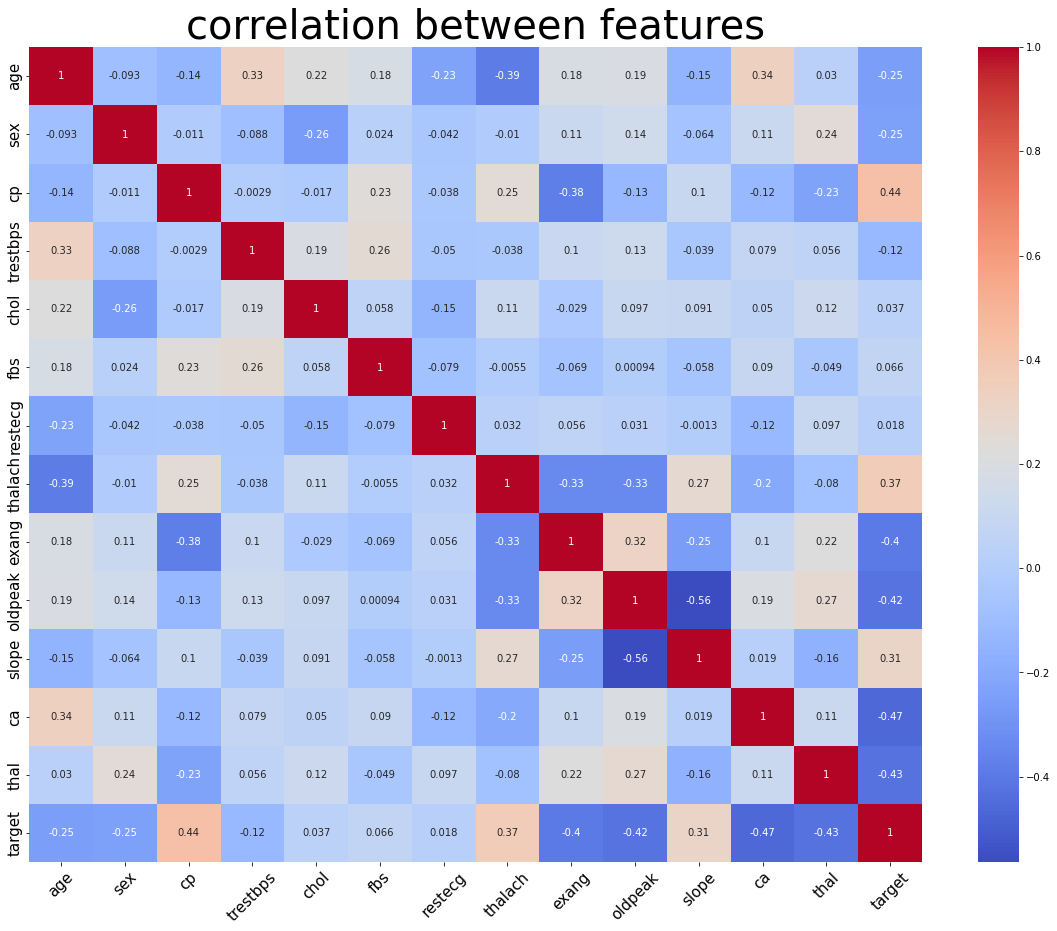

In [5]:
plt.figure(figsize=(20,15))

heat_table = train.drop(['id'], axis=1).corr()
heatmap_ax = sns.heatmap(heat_table, annot=True, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

In [6]:
# target과 다른 feature들의 상관계수는 아래와 같습니다.
corr_score = abs(heat_table.target[:-1])

# 상관계수 절대값을 기준으로 내림차순으로 정렬합니다.
corr_score.sort_values()

restecg     0.017528
chol        0.036991
fbs         0.065821
trestbps    0.122850
sex         0.246289
age         0.247806
slope       0.305994
thalach     0.365249
exang       0.396145
oldpeak     0.421514
thal        0.428530
cp          0.436273
ca          0.466289
Name: target, dtype: float64

In [7]:
from sklearn.preprocessing import StandardScaler 

# 먼저 PCA를 위해 데이터를 표준화해줍니다.
data = train.drop(['id', 'target'], axis=1).values
target = train['target'].values

scaled_data = StandardScaler().fit_transform(data)

In [8]:
from sklearn.decomposition import PCA

# 2D 에 시각화하기 위해 주성분을 2개로 선택합니다.
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
principalDf = pd.DataFrame(data=pca_data, columns = ['principal component 1', 'principal component 2'])
principalDf['target'] = target

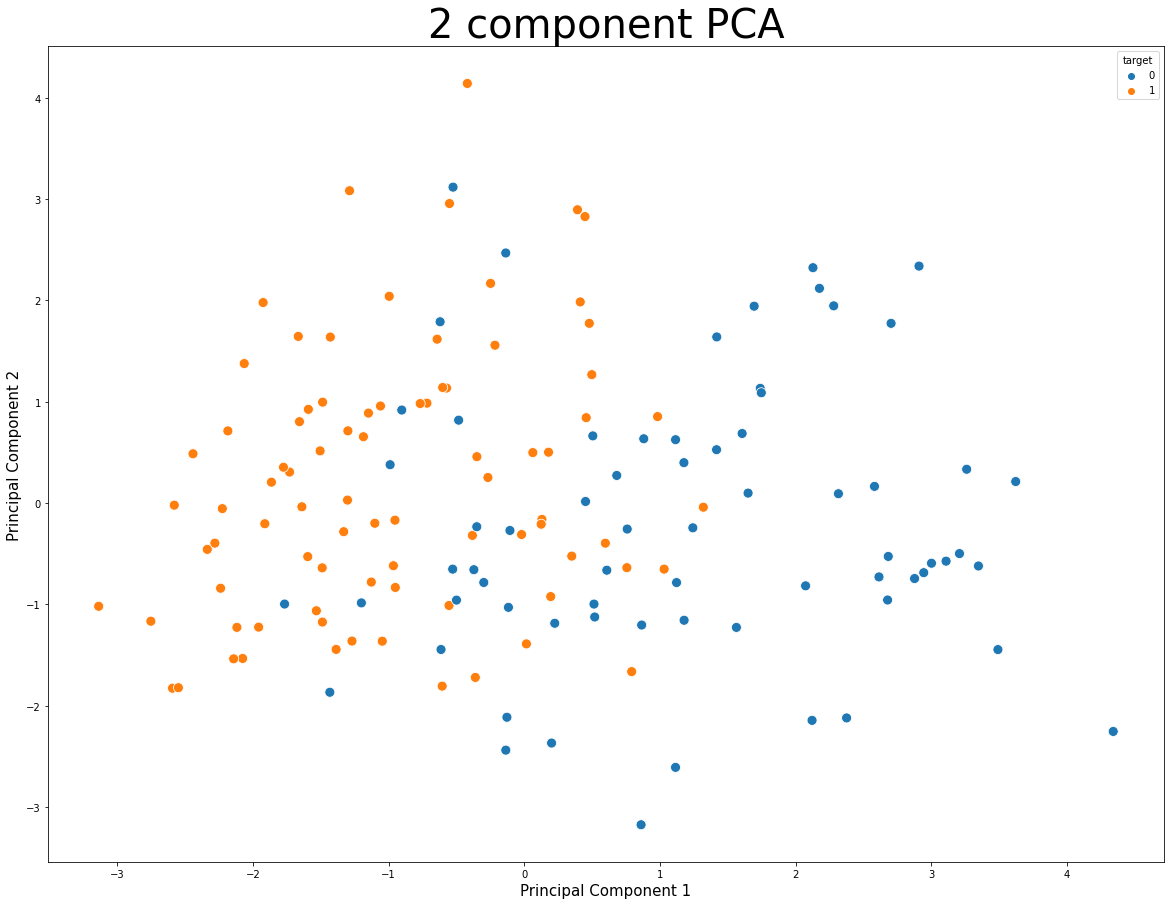

In [9]:
plt.figure(figsize = (20, 15))

plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 40)

sns.scatterplot(x='principal component 1', y='principal component 2', data=principalDf, hue='target', s= 100)
plt.show()

## Ridge Regression을 사용한 분류 모델

In [10]:
# 성능 변화 평가를 위해 data 나누기
X = train.iloc[:, 1:-1] 
Y = train.iloc[:, -1] 

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [11]:
# 성능 출력 함수
from sklearn.metrics import f1_score

def print_score(predicted, y):
    accuracy = sum(predicted == y) / len(y)*100
    f1 = f1_score(y, predicted)*100
    print(f'accuracy: {accuracy:.2f}%') # 정확도 출력
    print(f'f1_score : {f1:.2f}%') # f1 score 출력
    return accuracy, f1


check_acc = []
check_f1 = []

In [12]:
from sklearn.linear_model import Ridge

ridge_model1 = Ridge()
ridge_model1.fit(x_train, y_train)

#1단계 validaion
reg_preds = ridge_model1.predict(x_val)
preds = [1 if i > 0.5 else 0 for i in reg_preds]
acc, f1 = print_score(preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 83.87%
f1_score : 84.85%


In [13]:
best_model_train_x = x_train.drop(["restecg","chol","fbs","trestbps"],axis=1)
best_model_val_x = x_val.drop(["restecg","chol","fbs","trestbps"],axis=1)

ridge_model2 = Ridge(alpha=0.8)
ridge_model2.fit(best_model_train_x, y_train)

reg_preds = ridge_model2.predict(best_model_val_x)
preds = [1 if i > 0.6 else 0 for i in reg_preds] # 0.6일 때 성능이 더 높음
acc, f1 = print_score(preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 90.32%
f1_score : 90.32%


In [14]:
test = pd.read_csv("dataset/test.csv")

best_model_test = test.drop(["id","restecg","chol","fbs","trestbps"],axis=1)

In [15]:
# 값을 예측합니다.
prediction = ridge_model2.predict(best_model_test)

In [16]:
preds = [1 if i > 0.6 else 0 for i in prediction ]

In [17]:
# Ridge 회귀 함수의 threshold를 0.6이상으로 잡았을 때, 정확도가 급격히 상승함
submission = pd.read_csv('dataset/sample_submission.csv')
submission['target'] = preds
submission

,id,target
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1
...,...,...
147,148,0
148,149,0
149,150,0
150,151,1


In [18]:
submission.to_csv("ridge_submission.csv", index=False)

## Lasso Regression을 이용한 분류 모델

In [19]:
from sklearn.linear_model import Lasso
lasso_model1 = Lasso()
lasso_model1.fit(x_train, y_train)

#1단계 validaion
reg_preds = lasso_model1.predict(x_val)
preds = [1 if i > 0.5 else 0 for i in reg_preds]
acc, f1 = print_score(preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 58.06%
f1_score : 66.67%


In [20]:
lasso_model2 = Lasso()
lasso_model2.fit(best_model_train_x, y_train)

reg_preds = lasso_model2.predict(best_model_val_x)
preds = [1 if i > 0.5 else 0 for i in reg_preds]
acc, f1 = print_score(preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 64.52%
f1_score : 71.79%


## XGBoost를 사용한 분류 모델

In [21]:
import xgboost as xgb

params = {'max_depth' : 10,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
          "n_estimators" : 2000,
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

xgb_model = xgb.XGBRegressor(params=params)
xgb_model.fit(x_train, y_train)

#1단계 validaion
reg_preds = xgb_model.predict(x_val)
preds = [1 if i > 0.9 else 0 for i in reg_preds]
acc, f1 = print_score(preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

[15:38:51] WARNING: /tmp/xgboost/src/learner.cc:572: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuracy: 90.32%
f1_score : 89.66%


In [22]:
xgb_test = test.iloc[:, 1:] 
xgb_prediction = xgb_model.predict(xgb_test)

In [23]:
preds = [1 if i > 0.5 else 0 for i in xgb_prediction ]

In [24]:
submission = pd.read_csv('dataset/sample_submission.csv')
submission['target'] = preds
submission

,id,target
0,1,0
1,2,1
2,3,1
3,4,0
4,5,1
...,...,...
147,148,0
148,149,0
149,150,0
150,151,1


In [25]:
submission.to_csv("xgb_submission.csv", index=False)